In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc
from pyDOE import *
import os
from scipy.stats import norm

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 7 Text yticklabel objects>)

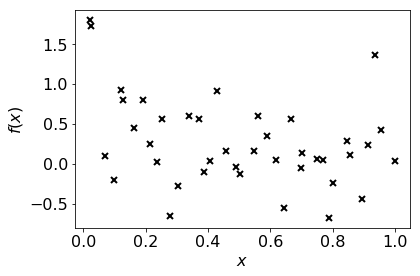

In [9]:
dim = 8
n = 10
noise=0
sigma = eval('lambda x: ' + str(noise))
# objective = Ex3Func(sigma=sigma)
# X = lhs(dim, n , criterion='center')
# Y = np.array([objective(x) for x in X])[:, None]
# Xnorm = X
X = np.load('../data/X_init_8d_40.npy')
# Y = np.array([objective(x) for x in X])[:, None]
# X = (X - 0.5) /0.5
Y = np.load('../data/Y_init_8d_40.npy') [:, 1][:, None]
fig, ax = plt.subplots()
ax.plot(X[:, 1], Y, 'x', markeredgewidth=2, color='black')
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$f(x)$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [3]:
# X = np.vstack([X[:-8, ], X[-6: -1, ]])
# Y = np.vstack([Y[:-8, ], Y[-6: -1, ]])

In [4]:
#build the model
k = gpflow.kernels.RBF(input_dim=1)
k.lengthscales.prior = gpflow.priors.Gamma(1, 1)
# from copy import copy
# l = copy(k)
noisekern = gpflow.kernels.RBF(input_dim=1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
mean_func = gpflow.mean_functions.Constant(1)
m = hetero_gpmc.GPMCAdaptiveLengthscaleMultDim(X, Y, k, nonstat, mean_func)

In [5]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp_multdim.V,[[ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.] [ 0. 0. 0. 0. 0. 0. 0. 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp_multdim.V4,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp_multdim.kern_type.lengthscales,[ 1.],"Ga([ 1.],[ 1.])",+ve
adaptive_lengthscale_gp_multdim.kern_type.variance,[ 1.],None,+ve
adaptive_lengthscale_gp_multdim.likelihood.variance,[ 1.],None,+ve
adaptive_lengthscale_gp_multdim.mean_func.c,[ 1.],None,(none)
adaptive_lengthscale_gp_multdim.nonstat.signal_variance,[ 1.],None,+ve


In [ ]:
# k = gpflow.kernels.RBF(input_dim=1)
# from copy import copy
# l = copy(k)
# print k
# print l

In [ ]:
for i in xrange(dim - 1):
    print i
    m.kerns["ell" + str(i)].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
    m.kerns["ell" + str(i)].variance.prior = gpflow.priors.Gamma(1., 1.)
    m.mean_funcs["ell" + str(i)].c = -2.
    m.mean_funcs["ell" + str(i)].c.fixed = True 
#     m.mean_funcs["ell" + str(i)].c.prior = gpflow.priors.Gamma(1., 2.)
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1., 2.)
# m.nonstat.signal_variance.fixed = True
m.likelihood.variance = 1e-6
m.likelihood.variance.fixed = True

In [ ]:
m.kerns["ell" + str(7)].lengthscales = 10.
m.kerns["ell" + str(7)].lengthscales.fixed = True
m.kerns["ell" + str(7)].variance = 10.
m.kerns["ell" + str(7)].variance.fixed = True 
m.mean_funcs["ell" + str(i)].c = -2.
m.mean_funcs["ell" + str(i)].c.fixed = True 

In [ ]:
m.optimize(maxiter=500) # start near MAP

In [ ]:
m

In [ ]:
mcmc_samples = 200
num_samp_gp = 1

In [ ]:
samples = m.sample(mcmc_samples, verbose=True, epsilon=0.00005, thin = 2, burn = 100, Lmax = 20)

In [ ]:
m

In [ ]:
m.get_feed_dict_keys()

In [ ]:
sample_df = m.get_samples_df(samples)
y_pos = []
num_post_samp = 1000
# xnew = np.linspace(0, 1, 100)[:,None]
xnew = np.load('../data/X_wire.npy')
ynew = np.load('../data/Y_wire.npy')
# xx = (xnew - 0.5) / 0.5
xx = xnew
mean_f_mat = np.zeros(shape=(num_samp_gp, xx.shape[0]))
mean_l_mat = np.zeros(shape=(num_samp_gp, xx.shape[0]))
var_f_mat = np.zeros(shape=(num_samp_gp, xx.shape[0]))
qoi_samp = []

## Plotting ${X_{i}}$  versus Y

In [ ]:
input_idx = 1
idx_sort = np.argsort(xnew[:, input_idx])
plt.plot(xnew[idx_sort[0:100], input_idx], ynew[0:100, 1])

In [ ]:
for i in range(mcmc_samples - num_samp_gp, mcmc_samples):
    idx = i - (mcmc_samples - num_samp_gp)
    m.set_parameter_dict(sample_df.iloc[i])
    mean_f, var_f = m.predict(xx)
    mean_l = m.predict_l(xx)
    mean_f_mat[idx, :] = mean_f[:, 0]
    var_f_mat[idx, :] = np.diag(var_f)

## Trace plots for some parameters

In [ ]:
print (mean_l[1][0]), (mean_l[1][6])

In [ ]:
trace_idx = 30
mcmc_samples_plot = 1000
plt.plot(np.arange(mcmc_samples_plot), samples[-mcmc_samples_plot:, trace_idx])

In [ ]:
err = abs(mean_f_mat.T - ynew[:, 1][:, None])
ynew_fwt = ynew[:, 1][:, None]
avg_pred = np.mean(mean_f_mat.T, axis=1)
plt.scatter(avg_pred, ynew_fwt)

In [ ]:
xnew = lhs(dim, 1000)
num_samp_gp = 1
for i in range(mcmc_samples - num_samp_gp, mcmc_samples):
    idx = i - (mcmc_samples - num_samp_gp)
    m.set_parameter_dict(sample_df.iloc[i])
#     samp, var = m.predict(xnew)
    samp = m.posterior_samples(xnew, num_post_samp)
    
#     import pdb
#     pdb.set_trace()
    samp_q = np.amin(samp, axis=1)
    print np.mean(samp_q), np.var(samp_q)

In [ ]:
# plt.scatter(ynew_fwt, np.percentile(samp, 50, axis=0))
[plt.scatter(xnew[:, 0], samp[i, :]) for i in xrange(num_post_samp)]
print np.amax(ynew_fwt)
print np.amax(avg_pred)

In [ ]:
std_f_mat = np.sqrt(var_f_mat)
Lowerf = mean_f_mat - 2 * std_f_mat
Upperf = mean_f_mat + 2 * std_f_mat
y_pos = np.vstack(y_pos)
y_m = np.percentile(y_pos, 50, axis=0)
y_l = np.percentile(y_pos, 2.5, axis=0)
y_u = np.percentile(y_pos, 97.5, axis=0)

In [ ]:
# m.set_parameter_dict(sample_df.iloc[4])
# p_samp = m.posterior_samples_n(xx, 10)

## Checking the pred_cov method

In [ ]:
x1 = xx[:1, 0][:, None] # 
x2 = xx[40:50, 0][:, None]
f = m.pred_cov(x1, x2)

In [ ]:
p, v = m.predict(xx)
print '>... squared difference b/w the rows of the posterior covariance matrix from the two methods is:', \
np.sum((f - v[:1, 40:50]) ** 2.)

## Visualizing the inferred latent function

In [ ]:
def visualize(Xgrid, Mgrid, Vargrid):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    Sd_epis = np.sqrt(Vargrid)
    
    lower = Mgrid - 2. * Sd_epis
    upper = Mgrid + 2. * Sd_epis
    
#     plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.05)
#     plt.fill_between(Xgrid[:,0], lower1, upper1,
#                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [ ]:
X_true = np.linspace(0, 1, 100)[:,None]
Y_true = np.array([objective(x) for x in X_true])[:, None]
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")

In [ ]:
mini = 100
maxi = 400
plt.figure(figsize=(12, 8))
for i in xrange(mini,maxi):
    visualize(X_true, mean_f_mat[i, :], var_f_mat[i, :])
plt.plot(X_true, y_m, '--', c='red', linewidth=3.0, label='physical response GP', zorder=1)
plt.fill_between(X_true[:, 0], y_l, y_u, color='red', alpha=1, zorder=3)
plt.plot(X_true, Y_true, 'k', zorder=-1)
plt.scatter(X , Y, marker='X', s=80, color='black')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16)

In [ ]:
def visualize_l(Xgrid, M):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'g', label = 'utility', alpha = 0.5)
#     plt.fill_between(Xgrid[:,0], L, U,
#                      color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$ell(x)$', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return

In [ ]:
mini = 0
maxi = 500
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, mean_l_mat[i,:])  

In [ ]:
mini = 10
maxi = 40
plt.figure(figsize=(12, 8))
for i in xrange(mini,maxi):
    visualize(X_true, mean_f_mat[i, :], var_f_mat[i, :])
plt.plot(X_true, y_m, '--', c='red', linewidth=3.0, label='physical response GP', zorder=1)
plt.fill_between(X_true[:, 0], y_l, y_u, color='red', alpha=1, zorder=3)
plt.plot(X_true, Y_true, 'k', zorder=-1)
plt.scatter(X * 0.5 + 0.5 , Y, marker='X', s=80, color='black')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16)


mini = 0
maxi = 50
for i in xrange(mini,maxi):
    visualize_l(xnew, mean_l_mat[i,:] -4.5)  